In [2]:
import os
from tqdm import tqdm
import PIL
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import torch
torch.manual_seed(0)
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
from torchvision.models import AlexNet, AlexNet_Weights
import torchvision.transforms as transforms
from torchvision.io import read_image

from torch.utils.tensorboard import SummaryWriter

In [3]:
device = "mps"

## Lognormal Code

In [4]:
def lognormal(x, a, mu, sigma):
    """
    Formula for the lognormal distribution.
    """
    scale = a / (x * sigma * np.sqrt(2 * np.pi))
    term = np.exp(-0.5 * np.square((np.log(x) - mu) / sigma))
    return scale * term

def get_weight_hist(weights, min_val=None, max_val=None):
    """
    Gets a histogram of the weights for a given model.
    Returns the middle of each bin + their count + the min and max value in the histogram.
    """
    params = weights.flatten()
    params = torch.abs(params)
    if min_val == None or max_val == None:
        min_val = params.min().item()
        max_val = params.max().item()
    bins = 50
    hist = torch.histc(params, bins=bins, min=min_val, max=max_val)
    bin_mids = np.array([min_val + i * (max_val - min_val) / bins + 0.5 * (max_val - min_val) / bins for i in range(bins)])
    hist = hist.detach().cpu().numpy()
    return bin_mids, hist, min_val, max_val

def get_lognormal_params(weights):
    """
    Gets lognormal parameters for a given set of weights.
    """
    bin_mids, hist, min_val, max_val = get_weight_hist(weights)
    popt, pcov = curve_fit(lognormal, bin_mids, hist, p0=(1, 0, 2))
    return popt, min_val, max_val

def compute_layer_rsq(weights, a, mu, sigma, min_val, max_val):
    """
    Computes r squared between a layer's weights and given parameters for a lognormal curve.
    """
    bin_mids, hist, _, _ = get_weight_hist(weights, min_val, max_val)
    y_fit = lognormal(bin_mids, a, mu, sigma)
    rsq = r2_score(y_fit, hist)
    return rsq

## Custom Optimizer

In [5]:
class LogNormalOptimizer(torch.optim.Optimizer):
    """
    Performs SGD with a custom lognormal step.
    """
    def __init__(self, params, lr, momentum, weight_decay, dampening=0, popts=False, min_val=False, max_val=False, a=10, b=4.61):
        """
        Standard initialization
        """
        defaults = dict(lr=lr, 
                        momentum=momentum, 
                        weight_decay=weight_decay, 
                        dampening=dampening, 
                        popts=popts, 
                        min_val=min_val, 
                        max_val=max_val,
                        a=a,
                        b=b)
        super(LogNormalOptimizer, self).__init__(params, defaults)


    def _init_group(self, group, params_with_grad, d_p_list, momentum_buffer_list):
        for p in group['params']:
            if p.grad is not None:
                params_with_grad.append(p)
                d_p_list.append(p.grad)
                if p.grad.is_sparse:
                    raise RuntimeError("What is a sparse gradient?")

                state = self.state[p]
                if 'momentum_buffer' not in state:
                    momentum_buffer_list.append(None)
                else:
                    momentum_buffer_list.append(state['momentum_buffer'])
        

    def sgd(self, params_with_grad, d_p_list, momentum_buffer_list, lr, momentum, weight_decay, dampening, popts, min_val, max_val, a, b):
        for i, param in enumerate(params_with_grad):

            d_p = d_p_list[i]

            # Weight decay
            if weight_decay != 0:
                d_p = d_p.add(param, alpha=weight_decay)

            # Momentum
            if momentum != 0:
                buf = momentum_buffer_list[i]

                if buf is None:
                    buf = torch.clone(d_p).detach()
                    momentum_buffer_list[i] = buf
                else:
                    buf.mul_(momentum).add_(d_p, alpha=1 - dampening)

                d_p = buf

            """
            This is where the lognormal optimization happen!
            R squared is computed between current weights and 'optimal' lognormal params.
            We use exponential decay to reduce learning rate the closer Rsq gets to 1 with:
            decay = a * e^(-b*Rsq)
            """
            if max_val:
                rsq = compute_layer_rsq(param, *popts, min_val, max_val)
                exp_decay = a * np.exp(-b * rsq)
                d_p = d_p.mul(exp_decay)

            param.data.add_(d_p, alpha=-lr)
            

    def step(self, closure=None):
        for group in self.param_groups:
            # Prepare group for backprop
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            self._init_group(group, params_with_grad, d_p_list, momentum_buffer_list)

            self.sgd(params_with_grad, 
                     d_p_list, 
                     momentum_buffer_list, 
                     group["lr"], 
                     group["momentum"], 
                     group["weight_decay"], 
                     group["dampening"], 
                     group["popts"], 
                     group["min_val"], 
                     group["max_val"],
                     group["a"],
                     group["b"])

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer
        

## Model Training

In [6]:
class CustomAlexNet(torch.nn.Module):
    """
    Custom AlexNet model that replaces the final linear classification layer with
    one with the correct number of outputs.
    Creates a module list for each layer so that we can store our lognormal parameters.
    """
    def __init__(self, n_classes):
        super().__init__()
        self.model = AlexNet()
        self.model.classifier[6] = torch.nn.Linear(4096, n_classes)

        self.params = torch.nn.ModuleDict({
            'layer0': torch.nn.ModuleList([self.model.features[0]]),
            'layer1': torch.nn.ModuleList([self.model.features[3]]),
            'layer2': torch.nn.ModuleList([self.model.features[6]]),
            'layer3': torch.nn.ModuleList([self.model.features[8]]),
            'layer4': torch.nn.ModuleList([self.model.features[10]]),
            'layer5': torch.nn.ModuleList([self.model.classifier[1]]),
            'layer6': torch.nn.ModuleList([self.model.classifier[4]]),
            'layer7': torch.nn.ModuleList([self.model.classifier[6]]),
        })

    def forward(self, X):
        return self.model.forward(X)

### Retrieve popts from trained model

In [7]:
def get_lognormal_from_saved_model(path):
    base_model = CustomAlexNet(10)
    base_model.load_state_dict(torch.load(path))

    popts = []
    mins = []
    maxes = []
    for l in range(len(base_model.params)):
        popt, min_val, max_val = get_lognormal_params(base_model.params[f"layer{l}"][0].weight)
        popts.append(popt)
        mins.append(min_val)
        maxes.append(max_val)

    lognormal_params = {"popts": popts, "mins": mins, "maxes": maxes}

    rsqs = []
    for l in range(len(base_model.params)):
        rsqs.append(compute_layer_rsq(base_model.params[f"layer{l}"][0].weight, *(popts[l]), mins[l], maxes[l]))

    return lognormal_params, rsqs

In [8]:
def train_model(train_ds, valid_ds, test_ds, lognormal_params=None, epochs=10, batch_size=128, lr=1e-2, momentum=0.9, weight_decay=0.0005):

    # Load data
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

    # Tensorboard
    if lognormal_params:
        run = f"{lognormal_params['a']}, {lognormal_params['b']}"
    else:
        run = f"base_{len(os.listdir(os.path.join(os.getcwd(), 'runs')))}"
    run_path = os.path.join(os.getcwd(), f"runs/{run}")
    writer = SummaryWriter(run_path)
    print(f"Logging to {run}")

    # Train setup
    model = CustomAlexNet(n_classes=10)
    model.to(device)

    if lognormal_params:
        print("Optimizing with lognormal params")
        # Set up parameters by layer
        params = [{'params': model.params[f"layer{l}"].parameters(),
                   'popts': lognormal_params['popts'][l],
                   'min_val': lognormal_params['mins'][l],
                   'max_val': lognormal_params['maxes'][l],
                   'a': lognormal_params['a'],
                   'b': lognormal_params['b']} for l in range(len(model.params))]
        optimizer = LogNormalOptimizer(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        print("Optimizing with SGD")
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    loss_fn = torch.nn.CrossEntropyLoss()

    step = 0
    train_losses = []
    for epoch in range(epochs):
        model.train()
        for img, label in tqdm(train_dl):
            # Train step
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            logits = model(img)
            loss = loss_fn(logits, label)
            loss.backward()
            optimizer.step()

            # Loss tracking
            writer.add_scalar("train_loss", loss.item(), step)
            train_losses.append(loss.item())
            step += 1

        # Evaluate epoch
        val_total = 0
        model.eval()
        with torch.no_grad():
            for img, label in tqdm(valid_dl):
                img, label = img.to(device), label.to(device)
                logits = model(img)
                # Loss tracking
                preds = torch.argmax(logits, dim=1)
                correct = torch.sum((preds.squeeze() == label.squeeze()).long()).item()
                val_total += correct
        print(f"epoch {epoch} accuracy: {val_total / (len(valid_ds))}")


    # Evaluate epoch
    test_total = 0
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(test_dl):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            # Loss tracking
            preds = torch.argmax(logits, dim=1)
            correct = torch.sum((preds.squeeze() == label.squeeze()).long()).item()
            test_total += correct
    test_acc = test_total / len(test_ds)
    print(f"test accuracy: {test_acc}")

    return model, train_losses, test_acc

In [9]:
# Load data
preprocess = AlexNet_Weights.IMAGENET1K_V1.transforms()
ds = CIFAR10(root=os.path.join(os.getcwd(), "data/cifar10"), train=True, transform=preprocess)
train_ds, valid_ds = torch.utils.data.random_split(ds, lengths=[0.8, 0.2], generator=torch.Generator().manual_seed(42))
test_ds = CIFAR10(root=os.path.join(os.getcwd(), "data/cifar10"), train=False, transform=preprocess)

In [10]:
def run_trial(lognormal_params, alexnet_hyperparams, a, b, epochs, trial_name):
    if a:
        print(f"Running lognormal trial {trial_name}")
        l_params = lognormal_params
        l_params["a"] = a
        l_params["b"] = b
    else:
        print(f"Running base trial {trial_name}")
        l_params = None
    model, losses, acc = train_model(train_ds, valid_ds, test_ds, lognormal_params=l_params, epochs=epochs, **alexnet_hyperparams)

    # Save losses
    path = f"saved/{trial_name}_epoch{epochs-1}"
    with open(f"{path}.pkl", "wb") as f:
        pickle.dump(losses, f)
    # Save model
    torch.save(model.state_dict(), f"{path}.pt")
    # Save acc
    with open(f"{path}.txt", "w") as f:
        f.write(str(acc))

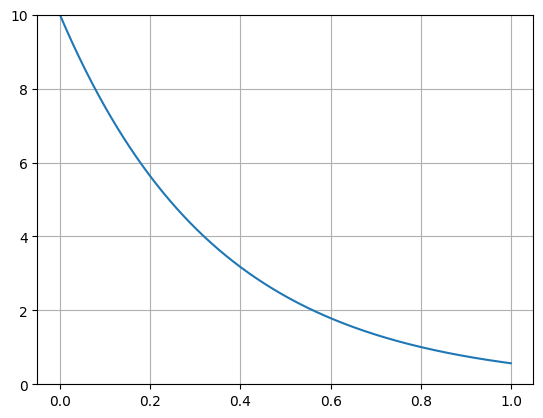

In [12]:
def calc_b_from_a(a):
    return np.log(a**2)

def plot_exp_decay(a, b):
    ys = []
    xs = list(range(0, 1000, 1))
    for x in xs:
        ys.append(a * np.exp(-b * x/1000))
    plt.ylim(0, max(ys))
    plt.grid()
    plt.plot([x / 1000 for x in xs], ys)
    plt.show()

plot_exp_decay(10, 2.87)

In [32]:
# Train model and get train loss
# Note: This will not work until you have run a base trial. Then you need to point to that saved trial.
lognormal_params, _ = get_lognormal_from_saved_model("saved/template/base_model_epoch9.pt")
alexnet_hyperparams = {"lr": 1e-2, "momentum": 0.9, "weight_decay": 0.0005, "batch_size": 128}
#A = [1.5, 2, 3, 5, 10]
a = 10
b = 2.87
trials = [
    # {"trial_name": "base",
    #  "alpha": None,
    #  "epochs": 1},
      {"trial_name": f"lognormala{a}b{b}",
      "a": a,
      "b": b,
      "epochs": 10}
]
for trial in trials:
    run_trial(lognormal_params, alexnet_hyperparams, **trial)

Running lognormal trial lognormala10b2.87
Logging to 8
Optimizing with lognormal params


100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


epoch 0 accuracy: 0.2833


 12%|█▏        | 38/313 [02:52<20:49,  4.55s/it]


KeyboardInterrupt: 

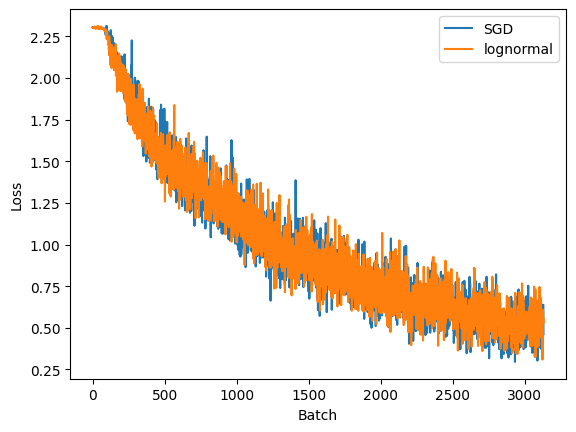

In [15]:
def plot_results(base_name, trial_list):
    with open(f"saved/{base_name}.pkl", "rb") as f:
        losses = pickle.load(f)
        plt.plot(range(len(losses)), losses, label="SGD")

    for trial in trial_list:
        with open(f"saved/{trial}.pkl", "rb") as f:
            lognormal_losses = pickle.load(f)
            plt.plot(range(len(lognormal_losses)), lognormal_losses, label=f"lognormal")

    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Batch")
    plt.show()

base_name = "base"
A = [1.5, 2, 3, 5, 10]
plot_list = [f"lognormala{a}b{calc_b_from_a(a)}_epoch9" for a in A]
plot_results(base_name, [plot_list[0]])